In [5]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.functions import struct
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

In [6]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *

MAX_MEMORY = '12G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 100000) \
        .set('spark.network.timeout', 100000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.bindAddress","localhost") \
        .set("spark.ui.port","4040") \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()

In [23]:
data = spark.read.parquet("./data/dataspark") \
.select("brand", "color", "fuelType", "year", "mileage", "transmission", "power", col("price").cast(IntegerType()).alias("label"))
data.show(10)

+-----+-----+--------+------------------+--------------------+------------+-------------------+-----+
|brand|color|fuelType|              year|             mileage|transmission|              power|label|
+-----+-----+--------+------------------+--------------------+------------+-------------------+-----+
|  8.0|  7.0|     0.0|0.9054054054054054|0.056056056056056056|         0.0| 0.5413290113452188|   46|
|  8.0|  1.0|     0.0|0.7297297297297297|  0.1991991991991992|         0.0|0.42625607779578606|   29|
|  3.0|  7.0|     0.0| 0.918918918918919| 0.14914914914914915|         0.0| 0.4343598055105348|   35|
|  2.0|  2.0|     0.0| 0.918918918918919|0.057057057057057055|         1.0|0.07455429497568881|    8|
|  0.0|  0.0|     0.0|0.9324324324324325| 0.01901901901901902|         0.0| 0.3209076175040519|   33|
|  2.0|  7.0|     0.0|0.8378378378378378| 0.03903903903903904|         1.0| 0.1312803889789303|    7|
|  2.0|  0.0|     0.0|0.7297297297297297| 0.13913913913913914|         1.0| 0.1847

In [24]:
splits = data.randomSplit([0.80, 0.20])
train = splits[0]
test = splits[1].withColumnRenamed("label", "trueLabel")
train_rows = train.count()
test_rows = test.count()
print("Training Rows:", train_rows, " Testing Rows:", test_rows)

Training Rows: 1178361  Testing Rows: 293929


In [8]:
arrayUDF = udf(lambda array: Vectors.dense(array),VectorUDT())

trainlr = train.withColumn("array",struct(train.brand, train.color, train.fuelType, \
        train.year, train.mileage, train.transmission, train.power)) \
        .select("array", "label") \
        .withColumn('features', arrayUDF(col('array'))) \
        .select("features", "label").repartition(1).cache()

testlr = test.withColumn("array",struct(test.brand, test.color, test.fuelType, \
        test.year, test.mileage, test.transmission, test.power)) \
        .select("array", "trueLabel") \
        .withColumn('features', arrayUDF(col('array'))) \
        .select("features", "trueLabel").repartition(1)

lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Fit the model
lrModel = lr.fit(trainlr)

predictions = lrModel.transform(testlr)

predictions.show()

evaluator = MulticlassClassificationEvaluator(labelCol='trueLabel')
print('Evaluation:', evaluator.evaluate(predictions))

from pyspark.ml.evaluation import RegressionEvaluator
rmse=RegressionEvaluator(labelCol="trueLabel", predictionCol="prediction", metricName="rmse")
rmse=rmse.evaluate(predictions) 
 
mae=RegressionEvaluator(labelCol="trueLabel", predictionCol="prediction", metricName="mae")
mae=mae.evaluate(predictions) 
 
r2=RegressionEvaluator(labelCol="trueLabel", predictionCol="prediction", metricName="r2")
r2=r2.evaluate(predictions)

mse=RegressionEvaluator(labelCol="trueLabel", predictionCol="prediction", metricName="mse")
mse=mse.evaluate(predictions)

print("RMSE: ", rmse)
print("MAE: ", mae)
print("R-squared: ", r2)
print("MSE: ", mse)

+--------------------+---------+--------------------+--------------------+----------+
|            features|trueLabel|       rawPrediction|         probability|prediction|
+--------------------+---------+--------------------+--------------------+----------+
|[0.0,0.0,0.0,0.40...|        4|[7.19975227538963...|[0.01209106959816...|       6.0|
|[0.0,0.0,0.0,0.40...|        4|[7.19975227538963...|[0.01209106959816...|       6.0|
|[0.0,0.0,0.0,0.40...|        4|[7.19975227538963...|[0.01209106959816...|       6.0|
|[0.0,0.0,0.0,0.43...|        0|[7.19975227538963...|[0.01209106959816...|       6.0|
|[0.0,0.0,0.0,0.43...|        0|[7.19975227538963...|[0.01209106959816...|       6.0|
|[0.0,0.0,0.0,0.43...|        0|[7.19975227538963...|[0.01209106959816...|       6.0|
|[0.0,0.0,0.0,0.43...|        0|[7.19975227538963...|[0.01209106959816...|       6.0|
|[0.0,0.0,0.0,0.43...|        0|[7.19975227538963...|[0.01209106959816...|       6.0|
|[0.0,0.0,0.0,0.43...|        0|[7.19975227538963...|[

In [5]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

# Scala version implements .roc() and .pr()
# Python: https://spark.apache.org/docs/latest/api/python/_modules/pyspark/mllib/common.html
# Scala: https://spark.apache.org/docs/latest/api/java/org/apache/spark/mllib/evaluation/BinaryClassificationMetrics.html
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

/usr/local/spark/python/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

Text(0.5, 0, 'false postitve rate')

Text(0, 0.5, 'true positive rate')

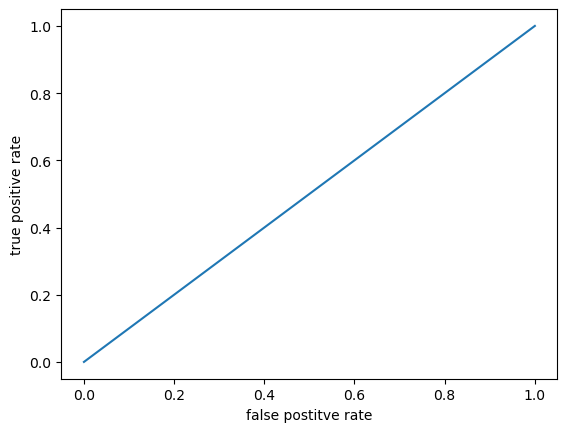

In [10]:
# Returns as a list (false positive rate, true positive rate)
preds = predictions.select('trueLabel','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['trueLabel'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.xlabel("false postitve rate")
plt.ylabel("true positive rate")
plt.plot(x_val, y_val)

In [38]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

arrayUDF = udf(lambda array: Vectors.dense(array),VectorUDT())

train_gbt = train.filter(train.label < 100) \
        .withColumn("array",struct(train.brand, train.color, train.fuelType, \
        train.year, train.mileage, train.transmission, train.power)) \
        .select("array", "label") \
        .withColumn('features', arrayUDF(col('array'))) \
        .select("features", "label").repartition(1).cache()

test_gbt = test.filter(test.trueLabel < 100) \
        .withColumn("array",struct(test.brand, test.color, test.fuelType, \
        test.year, test.mileage, test.transmission, test.power)) \
        .select("array", "trueLabel") \
        .withColumn('features', arrayUDF(col('array'))) \
        .select("features", "trueLabel").repartition(1).cache()

gbtr = GBTRegressor(labelCol = 'label', featuresCol = 'features', maxIter=150)
gbtr = gbtr.fit(train_gbt)

gbtr.transform(test_gbt).repartition(1).write.parquet("./data/ml2_1")

mdata = spark.read.parquet("./data/ml2_1")
 
rmse=RegressionEvaluator(labelCol="trueLabel", predictionCol="prediction", metricName="rmse")
rmse=rmse.evaluate(mdata) 
 
mae=RegressionEvaluator(labelCol="trueLabel", predictionCol="prediction", metricName="mae")
mae=mae.evaluate(mdata) 
 
r2=RegressionEvaluator(labelCol="trueLabel", predictionCol="prediction", metricName="r2")
r2=r2.evaluate(mdata)

mse=RegressionEvaluator(labelCol="trueLabel", predictionCol="prediction", metricName="mse")
mse=mse.evaluate(mdata)

print("RMSE (root mean squared error): ", rmse)
print("MAE (mean absolute error): ", mae)
print("R-squared: ", r2)
print("MSE (mean squared error): ", mse)

RMSE (root mean squared error):  2.947398543711178
MAE (mean absolute error):  1.8639586445143825
R-squared:  0.9482787212098963
MSE (mean squared error):  8.687158175470774


Text(0.5, 0, 'trueLabel')

Text(0, 0.5, 'prediction')

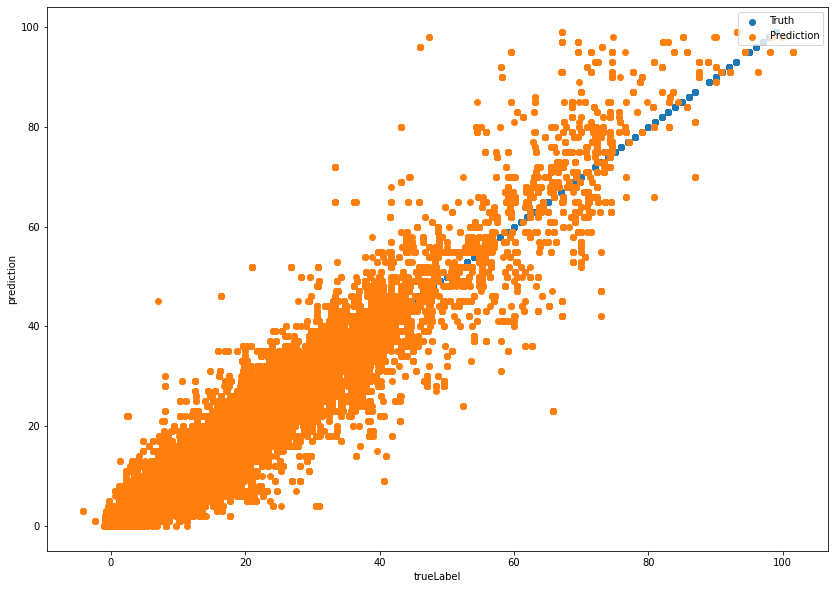

In [39]:
import matplotlib.pyplot as plt
dfvis = spark.read.parquet("./data/ml2_1")
fig, ax = plt.subplots(figsize=(14, 10))
ax.scatter(x = dfvis.select('trueLabel').collect(), y = dfvis.select('trueLabel').collect(), label='Truth')
ax.scatter(y = dfvis.select('trueLabel').collect(), x = dfvis.select('prediction').collect(), label='Prediction')
plt.xlabel("trueLabel")
plt.ylabel("prediction")
plt.legend(loc='upper right')

plt.show()

(array([3.6380e+03, 1.3815e+04, 1.5859e+04, 1.8273e+04, 1.9123e+04,
        1.7806e+04, 1.9845e+04, 1.9890e+04, 1.6507e+04, 1.4330e+04,
        8.5210e+03, 9.2810e+03, 1.0242e+04, 8.0400e+03, 6.5400e+03,
        7.5870e+03, 6.4490e+03, 6.1930e+03, 4.8660e+03, 4.3350e+03,
        3.1710e+03, 3.0730e+03, 3.0920e+03, 3.7810e+03, 3.0220e+03,
        3.6340e+03, 2.9240e+03, 2.4050e+03, 2.9040e+03, 2.9620e+03,
        1.9440e+03, 1.9770e+03, 1.5800e+03, 2.2150e+03, 1.8810e+03,
        1.7620e+03, 1.3870e+03, 1.3550e+03, 1.9830e+03, 1.4820e+03,
        9.5800e+02, 1.0240e+03, 8.3800e+02, 7.1300e+02, 6.5200e+02,
        5.5100e+02, 6.8200e+02, 5.0900e+02, 3.8500e+02, 4.3800e+02,
        2.8500e+02, 2.1200e+02, 4.6400e+02, 1.5800e+02, 6.1000e+01,
        4.8400e+02, 8.1000e+01, 2.8600e+02, 2.9100e+02, 1.5800e+02,
        6.9000e+01, 4.5000e+01, 2.2900e+02, 1.4000e+02, 7.1000e+01,
        1.8000e+02, 9.3000e+01, 1.7800e+02, 1.7200e+02, 1.5000e+02,
        1.7500e+02, 2.4300e+02, 1.3000e+02, 6.30

(array([3.0000e+00, 3.0000e+00, 4.0000e+00, 8.9000e+01, 5.7990e+03,
        1.4212e+04, 2.1303e+04, 1.9740e+04, 1.8498e+04, 2.0868e+04,
        2.0903e+04, 1.9487e+04, 1.7588e+04, 1.2792e+04, 8.9270e+03,
        1.0333e+04, 7.6740e+03, 7.0470e+03, 5.3900e+03, 7.7320e+03,
        7.5750e+03, 3.6970e+03, 4.0310e+03, 3.5170e+03, 4.2360e+03,
        3.7060e+03, 3.0540e+03, 3.4510e+03, 3.9350e+03, 2.3130e+03,
        2.2720e+03, 2.2250e+03, 2.5480e+03, 1.7370e+03, 1.8790e+03,
        2.0980e+03, 1.2900e+03, 1.8460e+03, 2.5900e+03, 2.2630e+03,
        1.6640e+03, 1.3250e+03, 8.1100e+02, 8.6300e+02, 9.6100e+02,
        6.5500e+02, 4.9900e+02, 2.4200e+02, 3.8900e+02, 4.6100e+02,
        2.2100e+02, 1.1300e+02, 2.2000e+02, 2.2200e+02, 3.7000e+02,
        2.2500e+02, 3.8200e+02, 2.8800e+02, 1.3500e+02, 1.7200e+02,
        1.7800e+02, 4.4000e+01, 2.2900e+02, 1.9800e+02, 2.0300e+02,
        1.4800e+02, 3.2500e+02, 2.2100e+02, 1.1500e+02, 3.2300e+02,
        2.7400e+02, 1.7300e+02, 2.8100e+02, 1.48

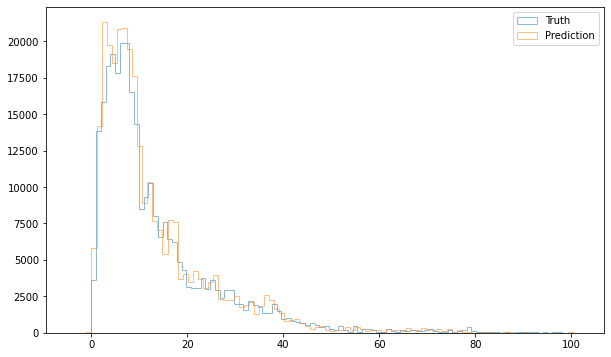

In [40]:
fig, ax = plt.subplots(figsize=(10, 6))
dfvis = spark.read.parquet("./data/ml2_1")
dfvisx = np.array(dfvis.select('trueLabel').collect())
dfvisy = np.array(dfvis.select('prediction').collect())
plt.hist(dfvisx, alpha=0.5, label='Truth',histtype='step', bins = 100)
plt.hist(dfvisy, alpha=0.5, label='Prediction',histtype='step', bins = 100)
plt.legend(loc='upper right')
plt.show()

(array([ 3638., 13815., 15859., 18273., 19123., 17806., 19845., 19890.,
        16507., 14330.,  8521.,  9281., 10242.,  8040.,  6540.,  7587.,
         6449.,  6193.,  4866.,  4335.,  3171.,  3073.,  3092.,  3781.,
         3022.,  3634.,  2924.,  2405.,  2904.,  2962.,  1944.,  1977.,
         1580.,  2215.,  1881.,  1762.,  1387.,  1355.,  1983.,  1482.,
          958.,  1024.,   838.,   713.,   652.,   551.,   682.,   509.,
          385.,   723.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.]),
 <BarContainer object of 50 artists>)

(array([ 4255., 13753., 17503., 20957., 16887., 19926., 19641., 18271.,
        17767., 15360., 10293.,  8280., 10124.,  6607.,  6695.,  4890.,
         7772.,  6882.,  3497.,  3753.,  3668.,  3963.,  3105.,  3543.,
         2927.,  3671.,  2628.,  2894.,  1322.,  2788.,  1805.,  1590.,
         2176.,  1619.,  1098.,  1801.,  2565.,  1756.,  2143.,  1082.,
          915.,   746.,   775.,   893.,   511.,   290.,   364.,   564.,
          167.,   173.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.]),
 <BarContainer object of 50 artists>)

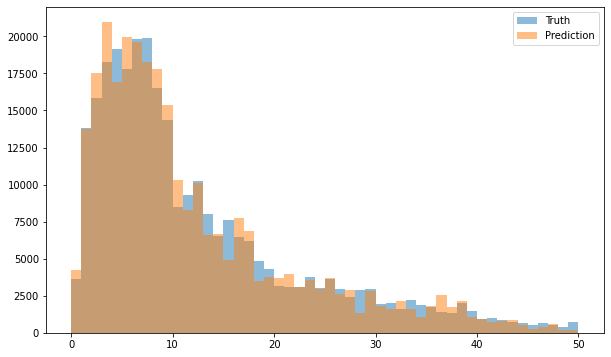

In [41]:
fig, ax = plt.subplots(figsize=(10, 6))
dfvis = spark.read.parquet("./data/ml2_1")
dfvisx = np.array(dfvis.select('trueLabel').collect())
dfvisy = np.array(dfvis.select('prediction').collect())
plt.hist(dfvisx, alpha=0.5, range=[0, 50], label='Truth', bins = 50)
plt.hist(dfvisy, alpha=0.5, range=[0, 50], label='Prediction', bins = 50)
plt.legend(loc='upper right')
plt.show()

### ТЕСТ

In [6]:
from pyspark.ml.evaluation import RegressionEvaluator
# библиотека алгортима случайного леса
from pyspark.ml.regression import RandomForestRegressor
arrayUDF = udf(lambda array: Vectors.dense(array),VectorUDT())
train_rf = train.withColumn("array",struct(train.brand, train.color, train.fuelType, \
        train.year, train.mileage, train.transmission, train.power)) \
        .select("array", "label") \
        .withColumn('features', arrayUDF(col('array'))) \
        .select("features", "label").repartition(1).cache()

test_rf = test.withColumn("array",struct(test.brand, test.color, test.fuelType, \
        test.year, test.mileage, test.transmission, test.power)) \
        .select("array", "trueLabel") \
        .withColumn('features', arrayUDF(col('array'))) \
        .select("features", "trueLabel").repartition(1).cache()

rf = RandomForestRegressor(featuresCol="features", labelCol='label', numTrees=10)
rfModel = rf.fit(train_rf)

rfModel.transform(test_rf).repartition(1).write.parquet("./data/ml3")

predictions = spark.read.parquet("./data/ml3")
 
rmse=RegressionEvaluator(labelCol="trueLabel", predictionCol="prediction", metricName="rmse")
rmse=rmse.evaluate(predictions) 
 
mae=RegressionEvaluator(labelCol="trueLabel", predictionCol="prediction", metricName="mae")
mae=mae.evaluate(predictions) 
 
r2=RegressionEvaluator(labelCol="trueLabel", predictionCol="prediction", metricName="r2")
r2=r2.evaluate(predictions)

mse=RegressionEvaluator(labelCol="trueLabel", predictionCol="prediction", metricName="mse")
mse=mse.evaluate(predictions)

print("RMSE (root mean squared error): ", rmse)
print("MAE (mean absolute error): ", mae)
print("R-squared: ", r2)
print("MSE (mean squared error): ", mse)



RMSE (root mean squared error):  7.815775067859719
MAE (mean absolute error):  4.172036007439412
R-squared:  0.7701101500769933
MSE (mean squared error):  61.08633991137759


Text(0.5, 0, 'trueLabel')

Text(0, 0.5, 'prediction')

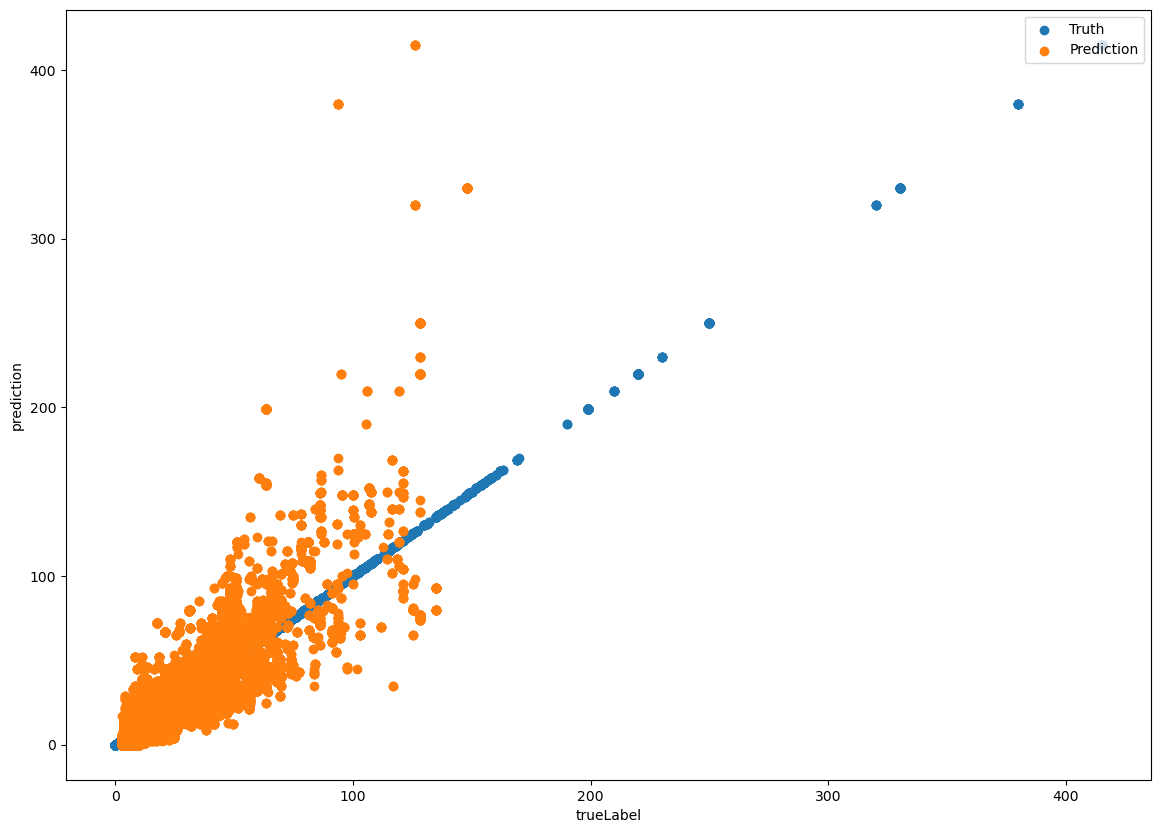

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(14, 10))
dfvis = predictions
ax.scatter(x = dfvis.select('trueLabel').collect(), y = dfvis.select('trueLabel').collect(), label='Truth')
ax.scatter(y = dfvis.select('trueLabel').collect(), x = dfvis.select('prediction').collect(), label='Prediction')
plt.xlabel("trueLabel")
plt.ylabel("prediction")
plt.legend(loc='upper right')

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

x = dfvis.select('trueLabel').collect()
y = dfvis.select('prediction').collect()

plt.hist(x, 15, alpha=0.5, label='Truth')
plt.hist(y, 15, alpha=0.5, label='Prediction')
plt.legend(loc='upper right')
plt.show()